<a href="https://colab.research.google.com/github/mrzebest/MachineDeepLearning/blob/main/Prediction_Meteo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
# ========================================
# 1. Importation des bibliothèques
# ========================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import kagglehub
import pandas as pd

In [76]:


# Download latest version
path = kagglehub.dataset_download("thomasdrabo/donnes-mto")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/donnes-mto


In [80]:
DATASET_PATH = './kaggle/input/donnes-mto'
!mkdir -p {DATASET_PATH}

!cp -r {path}/* {DATASET_PATH}/

In [83]:
# Charger le fichier CSV
df = pd.read_csv(f'{DATASET_PATH}/donnees.csv')

# Afficher les premières lignes du DataFrame
print(df.head())

    index           Date_Heure  Pression au niveau mer  \
0    7539  2013-01-01 04:00:00                101480.0   
1    9744  2013-01-01 07:00:00                101420.0   
2    7551  2013-01-01 10:00:00                101520.0   
3  114124  2013-01-01 13:00:00                101520.0   
4    7566  2013-01-01 16:00:00                101520.0   

   Variation de pression en 3 heures  Type de tendance barométrique  \
0                             -230.0                            6.0   
1                              -60.0                            5.0   
2                              100.0                            3.0   
3                                0.0                            0.0   
4                                0.0                            5.0   

   Direction du vent moyen 10 mn  Vitesse du vent moyen 10 mn  Température  \
0                           80.0                          4.6       282.55   
1                           10.0                          4.6       

# Data processing

In [84]:
df = df[["Date_Heure", "Température (°C)"]].dropna()
df = df.rename(columns={"Température (°C)": "temp"})

# Transformation du temps
df["Date_Heure"] = pd.to_datetime(df["Date_Heure"])
df.set_index("Date_Heure", inplace=True)

# Rééchantillonnage à l’heure
df = df.resample("1H").mean().dropna()

# Vérification que la colonne "temp" existe et contient bien des données numériques
assert "temp" in df.columns, "Colonne 'temp' manquante"
assert df["temp"].dtype in [float, int, "float64", "int64"], "Données non numériques dans 'temp'"

# Normalisation
scaler = MinMaxScaler()
df["temp_scaled"] = scaler.fit_transform(df[["temp"]])

/tmp/ipython-input-84-2298464350.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").mean().dropna()


In [85]:
# Création des séquences temporelles
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        window = data[i:i + window_size]
        label = data[i + window_size]
        sequences.append(window)
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 24
data = df["temp_scaled"].values
X, y = create_sequences(data, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [66]:
# Séparation entraînement / test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Modelisation

In [92]:
#  Modèle LSTM
model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# Entraînement
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0293 - val_loss: 0.0084
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 9/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 10/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0026 - val_loss: 0.0028


# Prediction

In [88]:
# Prédiction
y_pred = model.predict(X_test)

# Inversion de la normalisation
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [90]:
# Inversion de la normalisation
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Évaluation
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"MAE: {mae:.2f} °C, MSE: {mse:.2f}")

MAE: 1.73 °C, MSE: 6.19


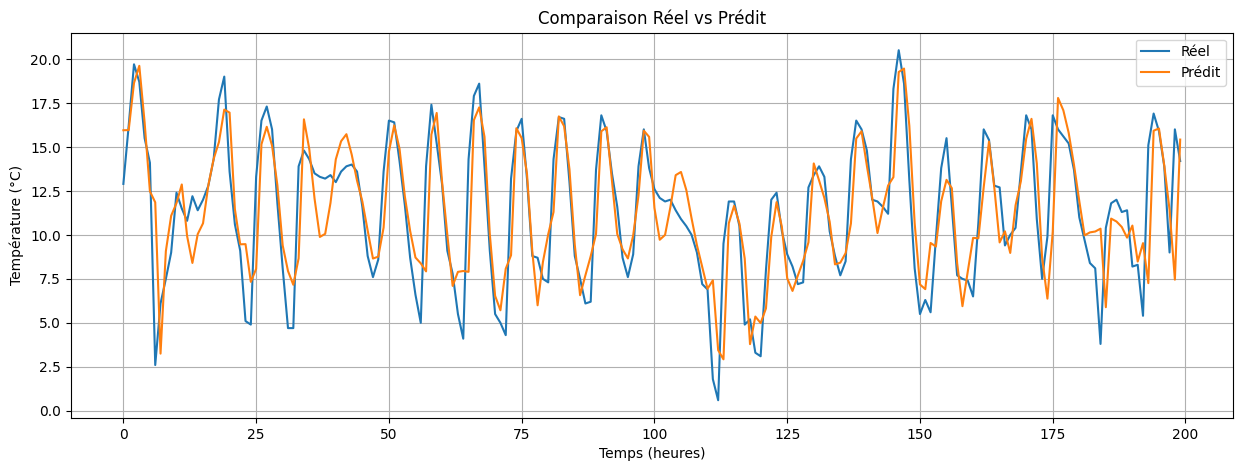

In [91]:
# Visualisation
plt.figure(figsize=(15,5))
plt.plot(y_test_inv[:200], label='Réel')
plt.plot(y_pred_inv[:200], label='Prédit')
plt.legend()
plt.title("Comparaison Réel vs Prédit")
plt.xlabel("Temps (heures)")
plt.ylabel("Température (°C)")
plt.grid()
plt.show()